In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os

In [4]:
num_classes = 345

In [5]:
files = os.listdir("data/QuickDraw")
print(files)

['aircraft carrier.npy', 'airplane.npy', 'alarm clock.npy', 'ambulance.npy', 'angel.npy', 'animal migration.npy', 'ant.npy', 'anvil.npy', 'apple.npy', 'arm.npy', 'asparagus.npy', 'axe.npy', 'backpack.npy', 'banana.npy', 'bandage.npy', 'barn.npy', 'baseball bat.npy', 'baseball.npy', 'basket.npy', 'basketball.npy', 'bat.npy', 'bathtub.npy', 'beach.npy', 'bear.npy', 'beard.npy', 'bed.npy', 'bee.npy', 'belt.npy', 'bench.npy', 'bicycle.npy', 'binoculars.npy', 'bird.npy', 'birthday cake.npy', 'blackberry.npy', 'blueberry.npy', 'book.npy', 'boomerang.npy', 'bottlecap.npy', 'bowtie.npy', 'bracelet.npy', 'brain.npy', 'bread.npy', 'bridge.npy', 'broccoli.npy', 'broom.npy', 'bucket.npy', 'bulldozer.npy', 'bus.npy', 'bush.npy', 'butterfly.npy', 'cactus.npy', 'cake.npy', 'calculator.npy', 'calendar.npy', 'camel.npy', 'camera.npy', 'camouflage.npy', 'campfire.npy', 'candle.npy', 'cannon.npy', 'canoe.npy', 'car.npy', 'carrot.npy', 'castle.npy', 'cat.npy', 'ceiling fan.npy', 'cell phone.npy', 'cello.n

In [6]:
sizes = []
for file in files:
    sizes.append(np.load("data/Quickdraw/" + file).shape[0])

KeyboardInterrupt: 

In [ ]:
min(sizes)

113613

In [ ]:
sum(sizes) * 784 / 1_000_000_000

39.534192544

In [7]:
data = np.load("data/QuickDraw/binoculars.npy")

In [8]:
data.shape

(124190, 784)

In [9]:
784 * 100_000 * 345 / 1_000_000_000

27.048

In [10]:
import matplotlib.pyplot as plt

In [11]:
offset = 0

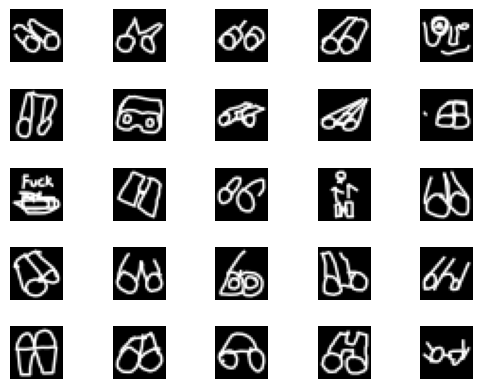

In [12]:
for i in range(25):
    image = data[i + offset]
    image = image.reshape(-1, 28, 28)

    plt.subplot(5, 5, i + 1)
    plt.imshow(image.squeeze(), cmap="gray")
    plt.axis("off")
offset += 25
plt.subplots_adjust(hspace=.5)
plt.show()

In [13]:
mmaps = []
for file in files:
    mmaps.append(np.load("data/QuickDraw/" + file, mmap_mode="r"))


In [14]:
print(type(torch.from_numpy(mmaps[0][0])).__name__)

Tensor


C:\Users\Andrew\AppData\Local\Temp\ipykernel_24276\3771942534.py:1: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_numpy.cpp:212.)
  print(type(torch.from_numpy(mmaps[0][0])).__name__)


In [15]:
t = torch.from_numpy(mmaps[0][0])
t = t.view(-1, 28, 28)
print(t.shape)

torch.Size([1, 28, 28])


In [16]:
class QuickDrawDataset(Dataset):
    """Quick, Draw! dataset."""

    def __init__(self, dir, max_bytes=None):
        """
        Arguments: 
            dir (string): Path to directory with QuickDraw .npy files. (ending in /)
        """
        self.dir = dir
        self.files = os.listdir(self.dir)
        self.mmaps = {}
        self.labels = [file.split(".")[0] for file in self.files]
        self.max_count = max_bytes // 784 if max_bytes is not None else None
        print(self.max_count)
        self.count = 0
        self._load(force=True)


    def _load(self, force=False):
        if force or (self.max_count is not None and self.count >= self.max_count):
            print("(re)loading")
            del self.mmaps

            self.mmaps = {}
            for file in self.files:
                self.mmaps[file.split(".")[0]] = np.load(self.dir + file, mmap_mode="r")


    def __len__(self):
        """
        First 100,000 of each file (min length is 113,613).
        I don't know how to make this different without possibly hurting the random sampling."
        """
        return 100_000 * len(self.files)

    def __getitem__(self, idx):
        self.count += 1
        self._load()
        label_idx = idx // 100_000 # choose label idx based on quotient
        label = self.labels[label_idx] # get label based on label idx
        img = self.mmaps[label][idx % 100_000] # index based on label, still mmap
        img = torch.from_numpy(img) # now is tensor
        img = img.view(28, 28) / 255

        return img, label

In [17]:
quickdraw = QuickDrawDataset("data/QuickDraw/", None)

None
(re)loading


In [18]:
quickdraw[0][0].dtype

torch.float32

0 torch.Size([28, 28]) aircraft carrier
1 torch.Size([28, 28]) aircraft carrier
2 torch.Size([28, 28]) aircraft carrier
3 torch.Size([28, 28]) aircraft carrier


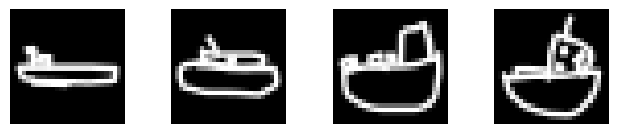

In [19]:
for i, (img, label) in enumerate(quickdraw):
    print(i, img.shape, label)

    plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")

    if i == 3:
        plt.show()
        break

In [20]:
print(len(quickdraw))

34500000


In [21]:
generator = torch.Generator().manual_seed(42)

In [22]:
train, test = torch.utils.data.random_split(quickdraw, [len(quickdraw) - 75000, 75000], generator=generator)

In [23]:
train

In [24]:
def train_dataloader(batch_size):
    training_data = train
    return DataLoader(
        training_data, shuffle=True, batch_size=batch_size, drop_last=True
    )

In [25]:
dataloader = train_dataloader(128)

In [26]:
for i, (X, y) in enumerate(dataloader):
    if i == 300000 // 128:
        break